# American Basket Option Pricing with Longstaff-Schwartz Method

This notebook demonstrates how to price American basket options using the Longstaff-Schwartz method. We'll simulate price paths for multiple assets using correlated Geometric Brownian Motion (GBM), calculate the basket price as a weighted sum of the assets, and then apply the Longstaff-Schwartz algorithm to price American and European options.

The Longstaff-Schwartz method uses regression to estimate the continuation value at each exercise date, allowing us to make optimal exercise decisions for American options.

## 1. Import Required Libraries and Classes

In [57]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
from typing import Literal
from numpy.polynomial import Polynomial

# Import directly from the module - reload if you've made changes
import importlib
import longstaff_schwartz
importlib.reload(longstaff_schwartz)

# Import specific classes from longstaff_schwartz module
from longstaff_schwartz import (
    CorrelatedGBM,
    PolynomialBasis,
    LSMOptionPricer
)

# Configure matplotlib for better visualization
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['lines.linewidth'] = 0.8

## 2. Set Simulation Parameters

Let's define the key parameters for our basket option pricing model:
- Number of assets in the basket
- Initial price for each asset
- Volatility for each asset
- Risk-free rate (used as drift for risk-neutral pricing)
- Time horizon
- Number of time steps
- Number of Monte Carlo simulations

In [58]:
# Parameters for the basket of assets
n_assets = 30  # Using 10 assets for faster execution in the notebook
S0 = [100] * n_assets  # All assets start at price 100
sigma = [0.2 + i * 0.01 for i in range(n_assets)]  # Different volatilities from 0.2 to 0.29

# Time and simulation parameters
T = 3 / 12  # 3 months in years
step = 60   # 60 time steps (approximately daily for 3 months)
N = 5000     # Number of simulation paths

# Risk-free rate and option strike price
r = 0.03    # 3% risk-free rate (used as drift in risk-neutral pricing)
K = 100     # Strike price (at-the-money)

print(f"Simulating {n_assets} assets over {T*12} months with {step} time steps")
print(f"Running {N} Monte Carlo simulations")
print(f"Risk-free rate: {r*100}%, Strike price: ${K}")

Simulating 30 assets over 3.0 months with 60 time steps
Running 5000 Monte Carlo simulations
Risk-free rate: 3.0%, Strike price: $100


## 3. Build Covariance Matrix

We'll create a block correlation structure:
- First group of assets: High correlation (0.7)
- Second group of assets: Medium correlation (0.4)
- Third group of assets: Low correlation (0.2)

Then we'll convert this correlation matrix to a covariance matrix using the volatilities.

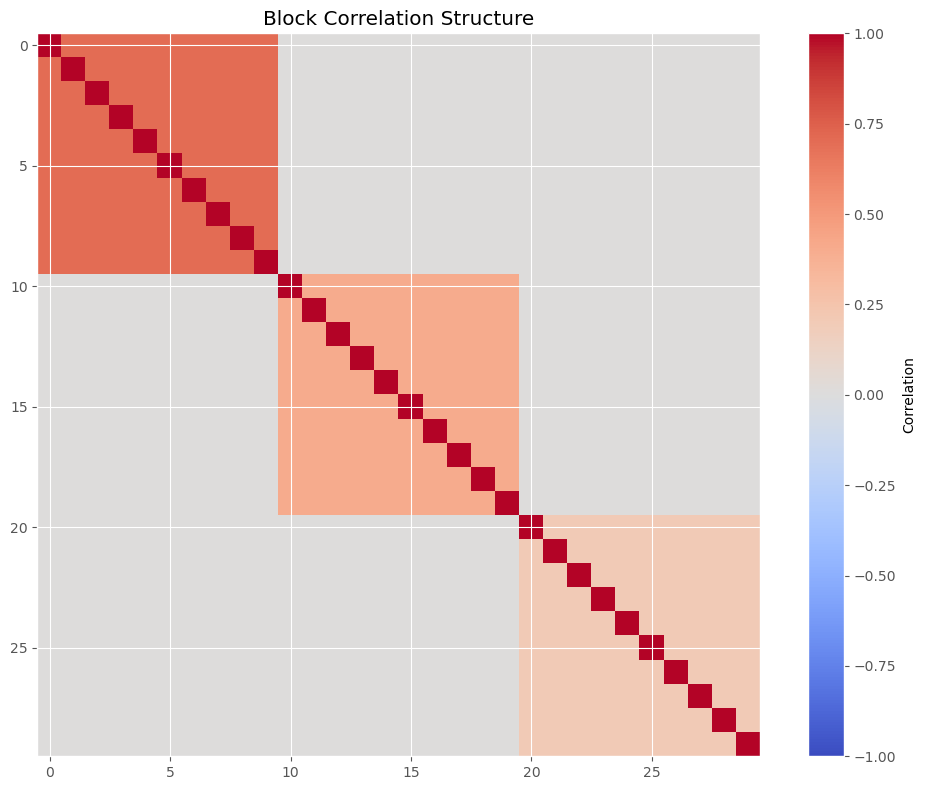

In [59]:
# Create correlation matrix (block correlation structure)
base_corr = np.eye(n_assets)

# Determine block sizes based on number of assets
block1 = n_assets // 3
block2 = block1 * 2

# First block: high correlation (0.7)
base_corr[:block1, :block1] = 0.7
np.fill_diagonal(base_corr[:block1, :block1], 1.0)

# Second block: medium correlation (0.4)
base_corr[block1:block2, block1:block2] = 0.4
np.fill_diagonal(base_corr[block1:block2, block1:block2], 1.0)

# Third block: low correlation (0.2)
base_corr[block2:, block2:] = 0.2
np.fill_diagonal(base_corr[block2:, block2:], 1.0)

# Build covariance matrix
cov = np.zeros((n_assets, n_assets))
for i in range(n_assets):
    for j in range(n_assets):
        cov[i, j] = base_corr[i, j] * sigma[i] * sigma[j]

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(base_corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Block Correlation Structure')
plt.tight_layout()
plt.show()

## 4. Simulate Correlated GBM Paths

Now let's use the `CorrelatedGBM` class to simulate price paths for our basket of assets under the risk-neutral measure. For option pricing, we use the risk-free rate (r) as the drift parameter to ensure risk-neutral pricing.

Using equal weights for all assets: 0.0333 each

Using risk-neutral pricing: using risk-free rate (r = 0.03) for drift

Generated paths shape: (5000, 61, 30)
  - 5000 simulation paths
  - 61 time steps
  - 30 assets

Generated paths shape: (5000, 61, 30)
  - 5000 simulation paths
  - 61 time steps
  - 30 assets


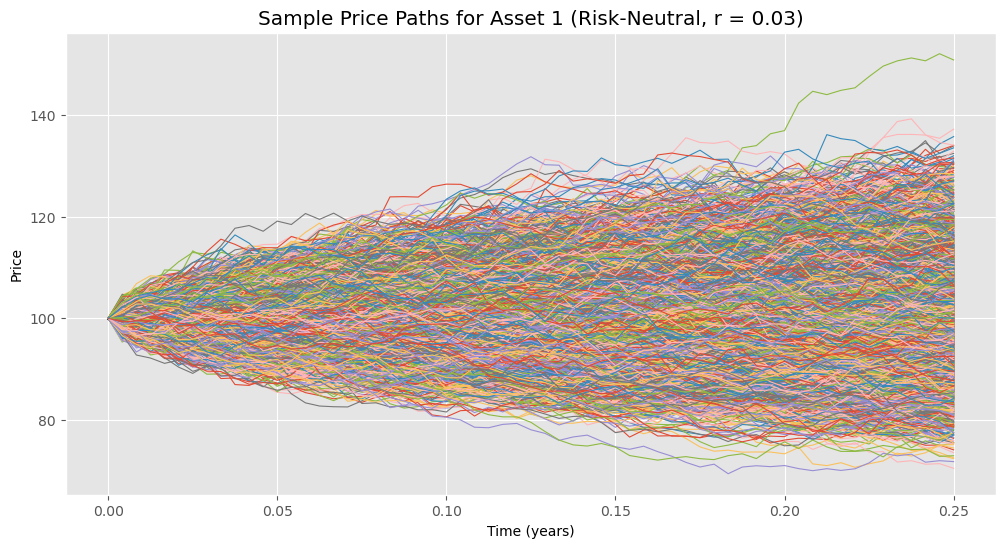

In [60]:
# Create equal weights for the basket
weights = np.ones(n_assets) / n_assets
print(f"Using equal weights for all assets: {weights[0]:.4f} each")

# Create the simulator using risk-free rate for risk-neutral pricing
print("\nUsing risk-neutral pricing: using risk-free rate (r = 0.03) for drift")

# Create the simulator
gbm_sim = CorrelatedGBM(S0, r, cov, T, step, N, weights)

# Generate paths
paths = gbm_sim.generate_paths()

# Print shape information
print(f"\nGenerated paths shape: {paths.shape}")
print(f"  - {N} simulation paths")
print(f"  - {step + 1} time steps")
print(f"  - {n_assets} assets")

# Display a few paths for the first asset
plt.figure(figsize=(12, 6))
for i in range(len(paths)):  # Plot first 5 paths
    plt.plot(np.linspace(0, T, step+1), paths[i, :, 0])
plt.title(f'Sample Price Paths for Asset 1 (Risk-Neutral, r = {r})')
plt.xlabel('Time (years)')
plt.ylabel('Price')
plt.grid(True)
plt.show()

## 5. Plot Basket Price Paths

Next, we'll look at the basket price paths, which represent the weighted average of all assets in our basket.

Basket paths shape: (5000, 61)
Final basket price statistics:
  - Mean: $100.82
  - Std Dev: $6.67
  - Min: $79.54
  - Max: $128.17


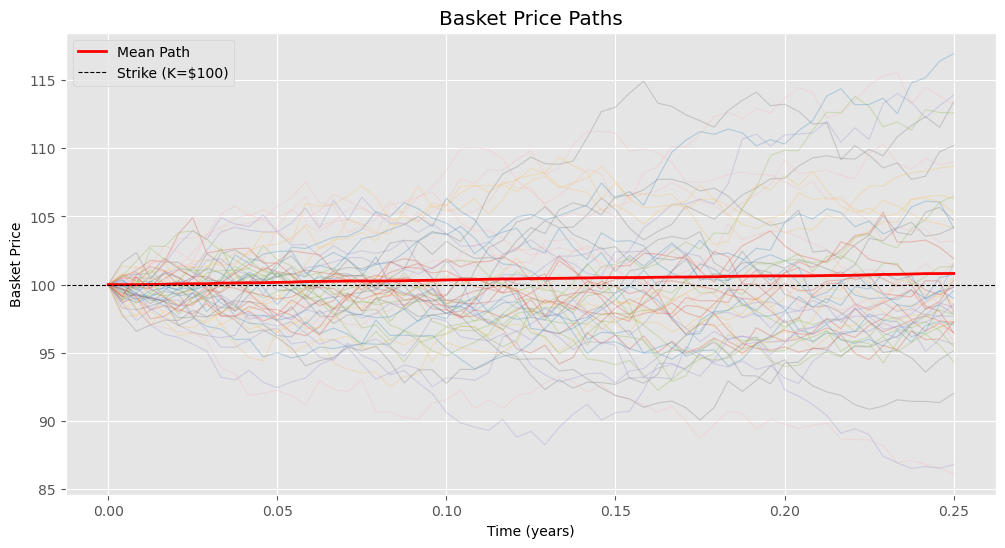

In [61]:
# Get basket price paths
basket_paths = gbm_sim.get_basket_paths()
print(f"Basket paths shape: {basket_paths.shape}")

# Calculate some statistics on final basket prices
final_prices = basket_paths[:, -1]
print(f"Final basket price statistics:")
print(f"  - Mean: ${np.mean(final_prices):.2f}")
print(f"  - Std Dev: ${np.std(final_prices):.2f}")
print(f"  - Min: ${np.min(final_prices):.2f}")
print(f"  - Max: ${np.max(final_prices):.2f}")

# Plot a sample of basket paths
plt.figure(figsize=(12, 6))
# Plot 50 random paths with low opacity
for i in np.random.choice(N, 50):
    plt.plot(np.linspace(0, T, step+1), basket_paths[i, :], alpha=0.3)
    
# Add the mean path
mean_path = np.mean(basket_paths, axis=0)
plt.plot(np.linspace(0, T, step+1), mean_path, 'r-', linewidth=2, label='Mean Path')

# Add the strike price
plt.axhline(y=K, color='k', linestyle='--', label=f'Strike (K=${K})')

plt.title('Basket Price Paths')
plt.xlabel('Time (years)')
plt.ylabel('Basket Price')
plt.legend()
plt.grid(True)
plt.show()

## 6. Price American Basket Put Option (Longstaff-Schwartz)

Now we'll price an American basket put option using the Longstaff-Schwartz method. This option can be exercised at any time point prior to maturity.

In [62]:
# Price the American basket put option using the LSMOptionPricer class
pricer = LSMOptionPricer(
    S0=S0, cov=cov, T=T, step=step, N=N,
    r=r, K=K, weights=weights, option="put"
)

# Simulate paths
pricer.simulate_paths()

# Price American option (allowing exercise at any time step)
american_price = pricer.price(basis=PolynomialBasis(degree=3))
print(f"American basket put option price: ${american_price:.4f}")

American basket put option price: $2.3712


## 7. Price European Basket Put Option

For comparison, we'll also price a European basket put option. This option can only be exercised at maturity.

In [63]:
# Price the European basket put option (exercise only at maturity)
european_price = pricer.price(exercise_grid=(step,))
print(f"European basket put option price: ${european_price:.4f}")

# We can also compute the European option price analytically for a basket
# But for a basket option, this is complex due to the basket distribution
# Instead, we can use the Monte Carlo estimate as our benchmark

European basket put option price: $2.2932


## 8. Calculate Early Exercise Premium

The difference between the American and European option prices represents the early exercise premium - the additional value from the ability to exercise the option before maturity.

Early exercise premium: $0.0780
Premium as percentage of European price: 3.40%


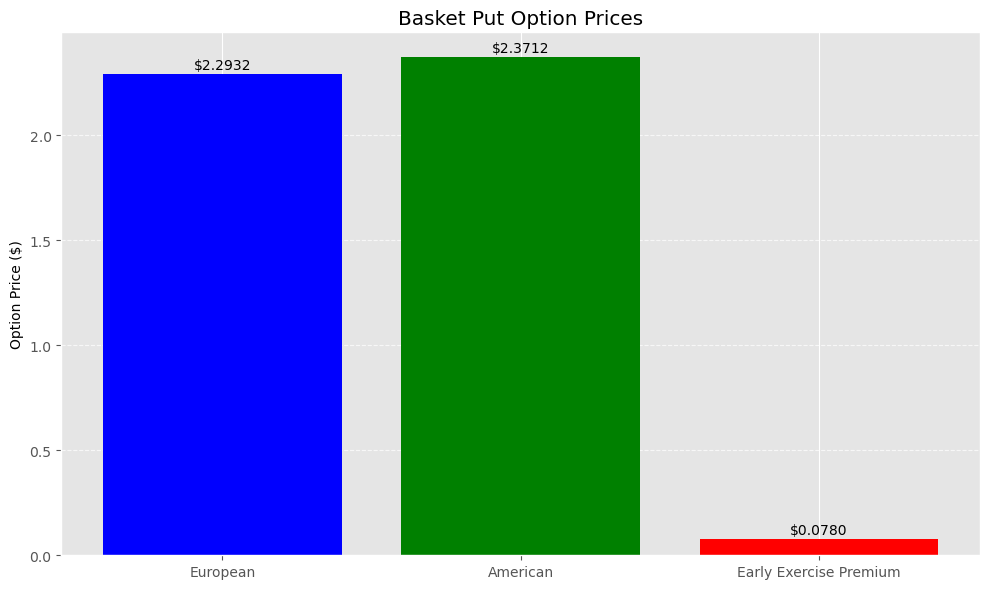

In [64]:
# Calculate the early exercise premium
early_exercise_premium = american_price - european_price
premium_percentage = (early_exercise_premium / european_price) * 100

print(f"Early exercise premium: ${early_exercise_premium:.4f}")
print(f"Premium as percentage of European price: {premium_percentage:.2f}%")

# Create a bar chart comparing the option prices
labels = ['European', 'American', 'Early Exercise Premium']
values = [european_price, american_price, early_exercise_premium]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['blue', 'green', 'red'])
plt.title('Basket Put Option Prices')
plt.ylabel('Option Price ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'${height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 9. Basket of Deltas (Individual Asset Sensitivities)

For a basket option, we can calculate how sensitive the option price is to changes in each individual asset price. This is called a "basket of deltas"

Baseline American put price: $2.3495
Baseline European put price: $2.2917

Calculating individual asset deltas (this may take some time)...
  Processed asset 1/30: American Δ = 0.0883, European Δ = 0.0243
  Processed asset 5/30: American Δ = 0.0959, European Δ = 0.0553
  Processed asset 10/30: American Δ = 0.0544, European Δ = 0.0431
  Processed asset 15/30: American Δ = -0.0419, European Δ = -0.1017
  Processed asset 20/30: American Δ = 0.0585, European Δ = 0.0887
  Processed asset 25/30: American Δ = 0.0088, European Δ = 0.0157
  Processed asset 30/30: American Δ = 0.0237, European Δ = -0.0062


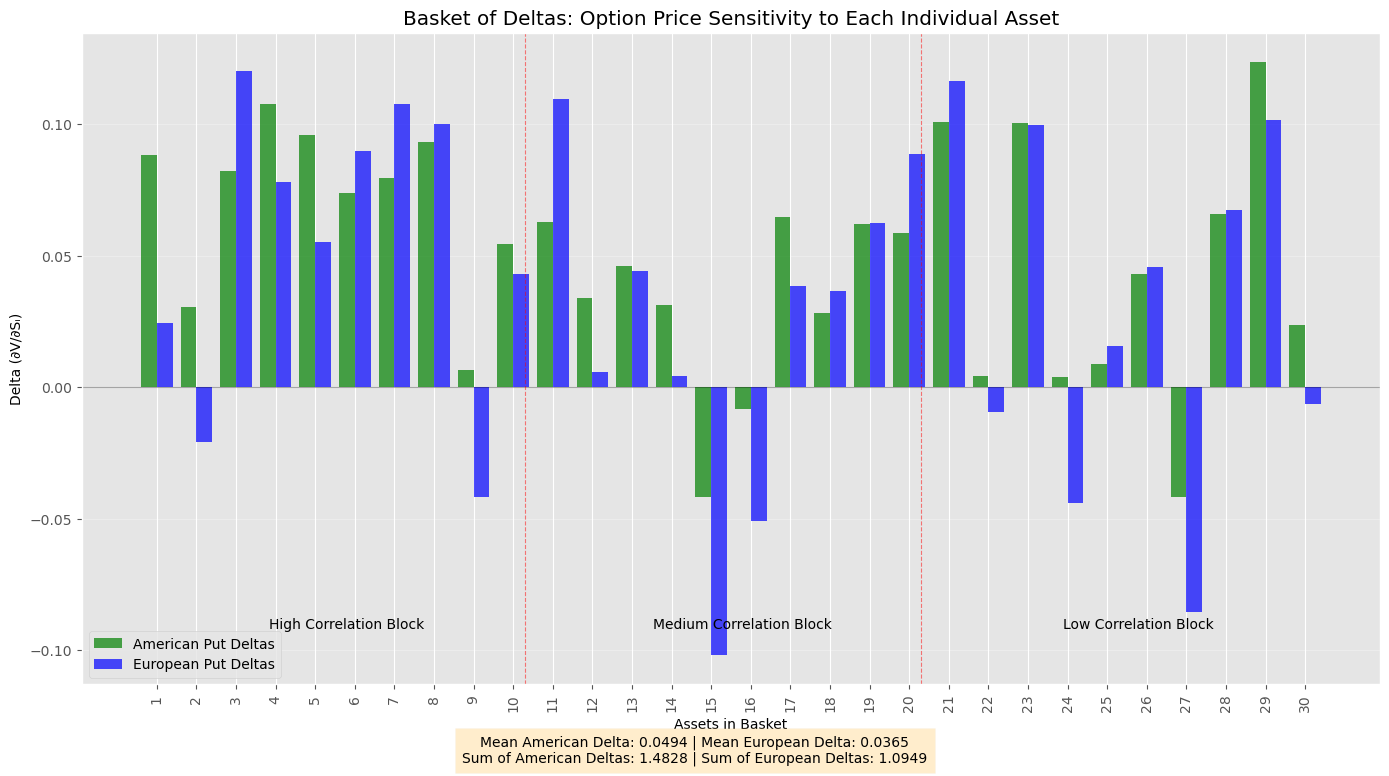

C:\Users\Ao Shen\AppData\Local\Temp\ipykernel_28124\1860080987.py:155: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


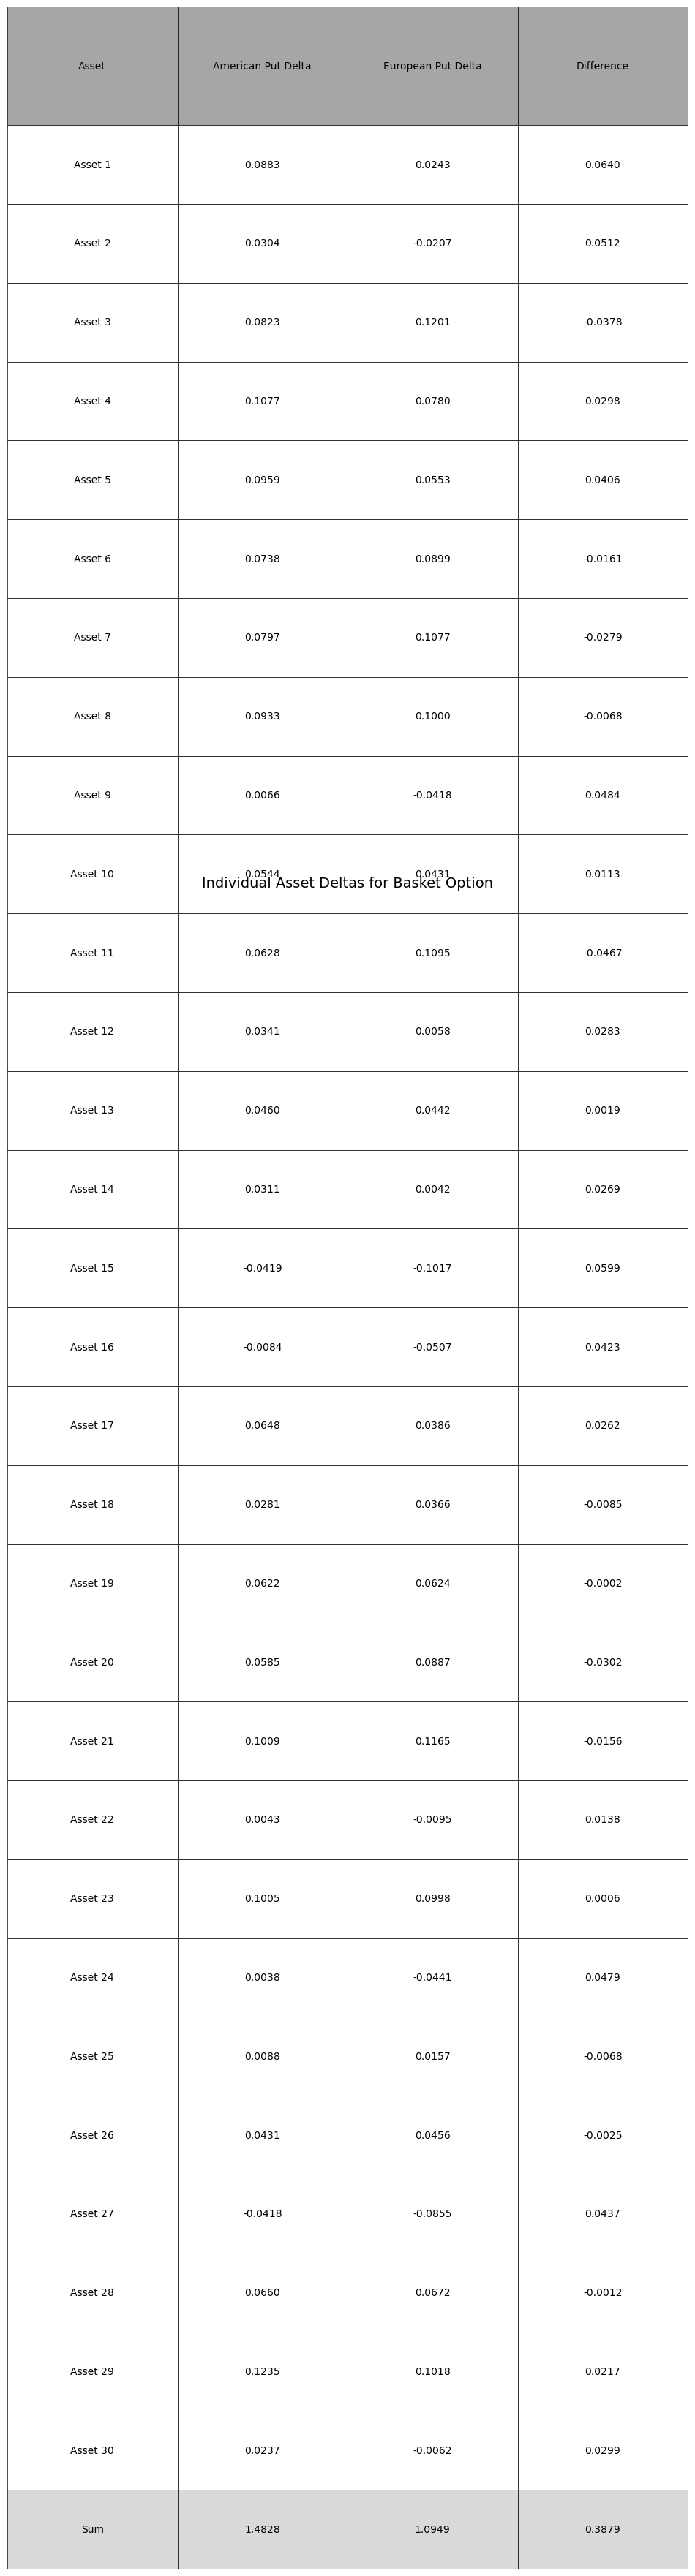


Top 5 assets with highest impact on option price:
--------------------------------------------------
Asset      American Δ      European Δ      Δ Diff          Weight    
--------------------------------------------------
Asset 29        0.1235          0.1018          0.0217       0.0333
Asset 4         0.1077          0.0780          0.0298       0.0333
Asset 21        0.1009          0.1165         -0.0156       0.0333
Asset 23        0.1005          0.0998          0.0006       0.0333
Asset 5         0.0959          0.0553          0.0406       0.0333


In [65]:
# Calculate the basket of deltas (individual asset sensitivities)
# This analysis shows how sensitive the option price is to changes in each individual asset

# Define shock size for numerical differentiation
shock_pct = 0.01  # 1% shock
base_S0 = S0.copy()  # Save original initial prices

# Initialize lists to store results
asset_names = [f"Asset {i+1}" for i in range(n_assets)]
american_deltas = []
european_deltas = []

# First, calculate baseline prices with no shock
baseline_pricer = LSMOptionPricer(
    S0=base_S0, cov=cov, T=T, step=step, N=N,
    r=r, K=K, weights=weights, option="put"
)
baseline_pricer.simulate_paths()
baseline_am_price = baseline_pricer.price(basis=PolynomialBasis(degree=3))
baseline_eu_price = baseline_pricer.price(exercise_grid=(step,))

print(f"Baseline American put price: ${baseline_am_price:.4f}")
print(f"Baseline European put price: ${baseline_eu_price:.4f}")
print(f"\nCalculating individual asset deltas (this may take some time)...")

# Calculate delta for each asset
for i in range(n_assets):
    try:
        # Create copy of initial prices
        shocked_S0 = base_S0.copy()
        
        # Apply shock to this specific asset only
        shock_amount = shocked_S0[i] * shock_pct
        shocked_S0[i] += shock_amount
        
        # Create pricer with shocked prices
        shocked_pricer = LSMOptionPricer(
            S0=shocked_S0, cov=cov, T=T, step=step, N=N,
            r=r, K=K, weights=weights, option="put"
        )
        
        # Price options with shocked price
        shocked_pricer.simulate_paths()
        shocked_am_price = shocked_pricer.price(basis=PolynomialBasis(degree=2))
        shocked_eu_price = shocked_pricer.price(exercise_grid=(step,))
        
        # Calculate deltas using finite difference (divided by shock amount)
        am_delta = -(shocked_am_price - baseline_am_price) / shock_amount
        eu_delta = -(shocked_eu_price - baseline_eu_price) / shock_amount
        
        american_deltas.append(am_delta)
        european_deltas.append(eu_delta)
        
        # Print progress
        if (i + 1) % 5 == 0 or i == 0 or i == n_assets - 1:
            print(f"  Processed asset {i+1}/{n_assets}: American Δ = {am_delta:.4f}, European Δ = {eu_delta:.4f}")
            
    except Exception as e:
        print(f"Error calculating delta for Asset {i+1}: {str(e)}")
        # If calculation fails, use a default value
        american_deltas.append(0)
        european_deltas.append(0)

# Convert to numpy arrays for visualization
american_deltas = np.array(american_deltas)
european_deltas = np.array(european_deltas)

# Visualize the basket of deltas
plt.figure(figsize=(14, 8))

# Define bar width and positions
bar_width = 0.4
r1 = np.arange(n_assets)
r2 = [x + bar_width for x in r1]

# Create grouped bar chart
plt.bar(r1, american_deltas, width=bar_width, color='green', alpha=0.7, label='American Put Deltas')
plt.bar(r2, european_deltas, width=bar_width, color='blue', alpha=0.7, label='European Put Deltas')

# Add labels and legend
plt.xlabel('Assets in Basket')
plt.ylabel('Delta (∂V/∂Sᵢ)')
plt.title('Basket of Deltas: Option Price Sensitivity to Each Individual Asset')
plt.xticks([r + bar_width/2 for r in range(n_assets)], [f"{i+1}" for i in range(n_assets)], rotation=90 if n_assets > 10 else 0)
plt.legend()
plt.grid(True, axis='y', alpha=0.3)

# Add horizontal line at y=0 for reference
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)

# Summary statistics
plt.figtext(0.5, 0.01, 
           f"Mean American Delta: {np.mean(american_deltas):.4f} | Mean European Delta: {np.mean(european_deltas):.4f}\n"
           f"Sum of American Deltas: {np.sum(american_deltas):.4f} | Sum of European Deltas: {np.sum(european_deltas):.4f}",
           ha='center', fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

# Add annotations for the block structure
if n_assets >= 3:
    plt.axvline(x=block1-0.5, color='red', linestyle='--', alpha=0.5)
    plt.axvline(x=block2-0.5, color='red', linestyle='--', alpha=0.5)
    plt.text(block1/2, min(min(american_deltas), min(european_deltas))*0.9, "High Correlation Block", ha='center')
    plt.text(block1 + (block2-block1)/2, min(min(american_deltas), min(european_deltas))*0.9, "Medium Correlation Block", ha='center')
    plt.text(block2 + (n_assets-block2)/2, min(min(american_deltas), min(european_deltas))*0.9, "Low Correlation Block", ha='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to make room for the text
plt.show()

# Create a table to display the actual delta values
from matplotlib.table import Table

# Create a new figure for the table
fig, ax = plt.subplots(figsize=(12, n_assets * 0.4 + 2))
ax.axis('off')

# Create the table data
table_data = []
headers = ['Asset', 'American Put Delta', 'European Put Delta', 'Difference']

for i in range(n_assets):
    diff = american_deltas[i] - european_deltas[i]
    table_data.append([f"Asset {i+1}", f"{american_deltas[i]:.4f}", f"{european_deltas[i]:.4f}", f"{diff:.4f}"])

# Add sum row
am_sum = np.sum(american_deltas)
eu_sum = np.sum(european_deltas)
diff_sum = am_sum - eu_sum
table_data.append(['Sum', f"{am_sum:.4f}", f"{eu_sum:.4f}", f"{diff_sum:.4f}"])

# Create the table
the_table = Table(ax, loc='center')

# Add rows to the table
n_rows = len(table_data)
n_cols = len(headers)

# Add the header row
cell_height = 0.15 if n_assets < 15 else 0.1
for j, header in enumerate(headers):
    the_table.add_cell(0, j, width=1/n_cols, height=cell_height*1.5, 
                      text=header, loc='center',
                      edgecolor='black', facecolor='#a6a6a6')

# Add the data rows
for i, row in enumerate(table_data, 1):
    for j, cell_text in enumerate(row):
        # Use different color for the sum row
        facecolor = '#d9d9d9' if i == n_rows else 'white'
        the_table.add_cell(i, j, width=1/n_cols, height=cell_height,
                          text=cell_text, loc='center',
                          edgecolor='black', facecolor=facecolor)

# Add the table to the plot
ax.add_table(the_table)
plt.title('Individual Asset Deltas for Basket Option', fontsize=14)
plt.tight_layout()
plt.show()

# Optional: Highlight assets with most significant impact
if True:
    # Sort assets by their American delta impact
    impact_indices = np.argsort(np.abs(american_deltas))[::-1]
    top_n = min(5, n_assets)  # Show top 5 or fewer if n_assets < 5
    
    print(f"\nTop {top_n} assets with highest impact on option price:")
    print("-" * 50)
    print(f"{'Asset':<10} {'American Δ':<15} {'European Δ':<15} {'Δ Diff':<15} {'Weight':<10}")
    print("-" * 50)
    
    for i in range(top_n):
        idx = impact_indices[i]
        print(f"Asset {idx+1:<5} {american_deltas[idx]:>10.4f}      {european_deltas[idx]:>10.4f}      {american_deltas[idx] - european_deltas[idx]:>10.4f}      {weights[idx]:>7.4f}")

Note that in a more complex analysis, we might also consider cross-delta effects